# Nonlinear Pendulum

This notebook details how the equation of motion for a pendulum consisting of a mass suspended from a massless, inextensible rod of length $l$ can be solved using traditional numerical methods and deep learning.

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
import torch
from torch import nn, autograd
from mpl_axes_aligner import align

plt.style.use("dark_background")

The equation of motion of the mass can be derived using Newtonian mechanics.

\begin{gather*}
    \sum F_r = T - mg\cos\theta = ml\dot{\theta}^2 \\
    \sum F_\theta = -mg\sin\theta - bl\dot{\theta} = ml\ddot{\theta} \\
    \ddot{\theta} = -\frac{g}{l} \sin\theta - \frac{b}{m} \dot{\theta}
\end{gather*}

The equation of motion can be solved for $\theta(t)$ given the physical constants in the equation of motion, $\theta(0) = \theta_0$ and $\dot{\theta}(0) = \omega_0$. 

Define physical constants and initial conditions.

In [3]:
g = 9.8
l = 1
m = 1
b = 1

theta_0 = np.pi/6
omega_0 = 0

## Method 1: Runge-Kutta Method

The equation of motion can be transformed into a first order initial value problem (i.e. $y'(t) = f(t, y(t))$) which can be solved numerically using Runge-Kutta methods.

$$\frac{d}{dt} \begin{bmatrix} \theta \\ \omega \end{bmatrix} = \begin{bmatrix} \omega \\ -\frac{g}{l} \sin\theta - \frac{b}{m} \omega \end{bmatrix}$$

with initial conditions $\theta(0) = \theta_0$ and $\omega(0) = \omega_0$

Define $f(t, y(t)) = y'(t)$

In [4]:
def f(t, y):
    return np.array([y[1], - g / l * np.sin(y[0]) - b / m * y[1]])

Numerically solve using Scipy.

In [91]:
t_end = 10
h = 0.02

y0 = np.array([theta_0, omega_0])

num_solution = solve_ivp(f, (0, t_end), y0, t_eval=np.arange(0, t_end + h, h))

Plot the results.

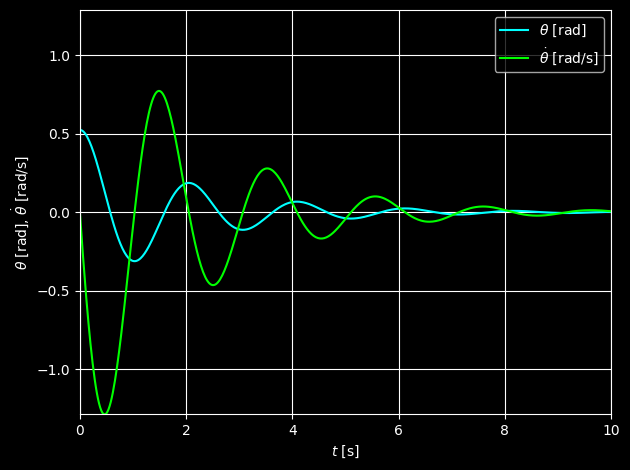

In [92]:
fig, ax = plt.subplots()

ax.plot(num_solution.t, num_solution.y[0], color="cyan")
ax.plot(num_solution.t, num_solution.y[1], color="lime")

ax.set_xlim([num_solution.t[0], num_solution.t[-1]])
ax.set_ylim([-np.max(np.abs(num_solution.y)), np.max(np.abs(num_solution.y))])
ax.set_xlabel(r"$t$ [s]")
ax.set_ylabel(r"$\theta$ [rad], $\dot{\theta}$ [rad/s]")
ax.legend([r"$\theta$ [rad]", r"$\dot{\theta}$ [rad/s]"], loc="upper right")
ax.grid()

fig.tight_layout()

fig.savefig("output/numerical_plot.png", dpi=300)
plt.show()

## Method 2: Physics Informed Neural Networks

The universal approximation theorem states that a neural network can be trained to approximate the solution to the equation of motion for given initial conditions and parameters.

$$NN(t; \Theta) \approx \theta(t)$$

Here, $\Theta$ represents the weights and biases of the neural network.

We use the same values of the physical constants and initial conditions as in Method 1 and train the neural network over the domain $t \in [0, 10]$.

The PINN is trained with the following loss function, which consists of a boundary loss terms $L_\theta$ and $L_\omega$ (which enforces the initial conditions), and a physics loss term $L_p$ (which enforces the equation of motion at a set of uniformly spaced collocation points $\{t_i\} \subset [0, 10]$).

$$L_\theta(\Theta) = \left(NN(0; \Theta) - \theta_0\right)^2$$

$$L_\omega(\Theta) = \left(\frac{dNN}{dt}(0; \Theta) - \omega_0\right)^2$$

$$L_p(\Theta) = \frac{1}{N} \sum_{i = 1}^N \left(\frac{d^2NN}{dt}(t_i; \Theta) + \frac{b}{m} \frac{dNN}{dt}(t_i; \Theta)+ \frac{g}{l} \sin\left(NN(t_i; \Theta)\right) \right)^2$$

$$L(\Theta) = L_\theta(\Theta) + \lambda_1 L_\omega(\Theta) + \lambda_2 L_p(\Theta)$$

This loss function was inspired by the [ETH Zurich Deep Learning in Scientific Computing course (2023)](https://camlab.ethz.ch/teaching/deep-learning-in-scientific-computing-2023.html). The parameters $\lambda_1$ and $\lambda_2$ were found by trial and error.

The PINN's weights and biases are initialised using Xavier initialisation and optimised using the Adam optimiser.

In [104]:
class PINN(nn.Module):
    def __init__(self, layers, activation_function):
        super().__init__()
        self.model = nn.Sequential()

        for i in range(1, len(layers)):
            layer = nn.Linear(layers[i-1], layers[i])

            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

            self.model.append(layer)

            if i != len(layers) - 1:
                self.model.append(activation_function)
    
    def forward(self, x):
        return self.model(x)
    
def residual(theta, t):
    dtheta_dt = torch.autograd.grad(theta, t, torch.ones_like(theta), create_graph=True)[0]
    d2theta_dt2 = torch.autograd.grad(dtheta_dt, t, torch.ones_like(dtheta_dt), create_graph=True)[0]

    return d2theta_dt2 + b / m * dtheta_dt + g / l * torch.sin(theta)

def train(pinn, t_initial, t_physics, t_test, learning_rate, epochs, save_path=None, ):
    optimiser = torch.optim.Adam(pinn.parameters(), lr=learning_rate)

    losses = np.empty((epochs, 4))
    solutions = np.empty((epochs, 3, len(t_test.detach())))

    for epoch in range(1, epochs + 1):
        optimiser.zero_grad()

        lambda_1, lambda_2 = 1, 1e-1

        theta_initial = pinn(t_initial)
        theta_physics = pinn(t_physics)

        initial_theta_loss = (torch.squeeze(theta_initial) - torch.tensor(theta_0)) ** 2
    
        dtheta_dt_initial = torch.autograd.grad(theta_initial, t_initial, create_graph=True)[0]
        initial_omega_loss = (torch.squeeze(dtheta_dt_initial) - torch.tensor(omega_0)) ** 2

        physics_loss = torch.mean(residual(theta_physics, t_physics) ** 2)
    
        loss = initial_theta_loss + lambda_1 * initial_omega_loss + lambda_2 * physics_loss
    
        loss.backward()
        optimiser.step()

        losses[epoch - 1] = np.squeeze(np.array([loss.detach(),
                                                initial_theta_loss.detach(),
                                                lambda_1 * initial_omega_loss.detach(),
                                                lambda_2 * physics_loss.detach()]))

        theta_test = pinn(t_test)
        test_residuals = residual(theta_test, t_test)
        test_grad_residuals = torch.autograd.grad(test_residuals, t_test, torch.ones_like(test_residuals), create_graph=True)[0]

        solutions[epoch - 1] = np.squeeze(np.array([theta_test.detach(), test_residuals.detach(), test_grad_residuals.detach()]))
    
    if save_path:
        torch.save(pinn, save_path)
        print("Model saved at ", save_path)
    
    return pinn, losses, solutions

In [106]:
torch.manual_seed(88)

hidden_width = 20
hidden_depth = 6

layers = [hidden_width for i in range(hidden_depth + 2)]
layers[0] = 1
layers[-1] = 1

pinn = PINN(layers, nn.Tanh())

t_initial = torch.tensor(0.0).view(-1, 1).requires_grad_(True)

num_physics_pts = 80
t_physics = torch.linspace(0, t_end, num_physics_pts).view(-1, 1).requires_grad_(True)

t_test = torch.arange(0, t_end + h, h).view(-1, 1).requires_grad_(True)

lr, epochs = 5e-3, 10000 

description = f"hidden_{hidden_depth}_{hidden_width}_t_0_{t_end}_n_{num_physics_pts}_lr_{lr}_epochs_{epochs}"
save_path = "models/pendulum_pinn_" + description + ".pt"

pinn, losses, solutions = train(pinn, t_initial, t_physics, t_test, lr, epochs, save_path)

Model saved at  models/pendulum_pinn_hidden_6_20_t_0_10_n_80_lr_0.005_epochs_10000.pt


Plot the loss curve.

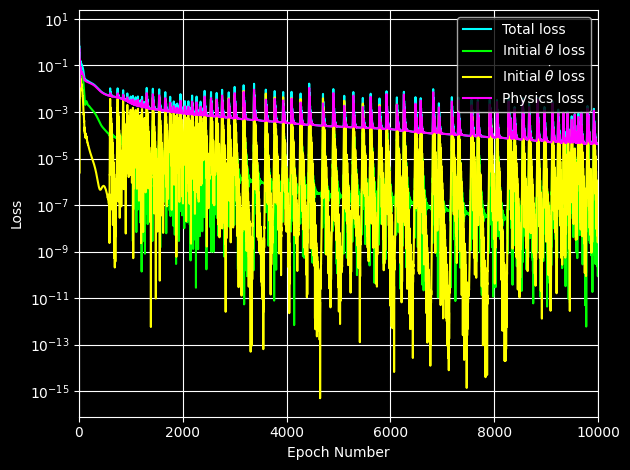

In [107]:
fig, ax = plt.subplots()

ax.plot(np.arange(1, losses.shape[0] + 1), losses[:, 0], color="cyan")
ax.plot(np.arange(1, losses.shape[0] + 1), losses[:, 1], color="lime")
ax.plot(np.arange(1, losses.shape[0] + 1), losses[:, 2], color="yellow")
ax.plot(np.arange(1, losses.shape[0] + 1), losses[:, 3], color="magenta")
ax.set_yscale('log')
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss")
ax.set_xlim([0, losses.shape[0]])
ax.legend(["Total loss", r"Initial $\theta$ loss", r"Initial $\dot \theta$ loss", "Physics loss"], loc="upper right")
ax.grid()

fig.tight_layout()

fig.savefig("output/loss_plot_" + description + ".png", dpi=300)
plt.show()

TODO: [Adaptive loss balancing](https://towardsdatascience.com/improving-pinns-through-adaptive-loss-balancing-55662759e701), [avoiding trivial solutions](https://arxiv.org/abs/2112.05620)

Plot the PINN computed solution

C:\Users\vsn88\AppData\Local\Temp\ipykernel_15988\260825193.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn = torch.load(save_path)


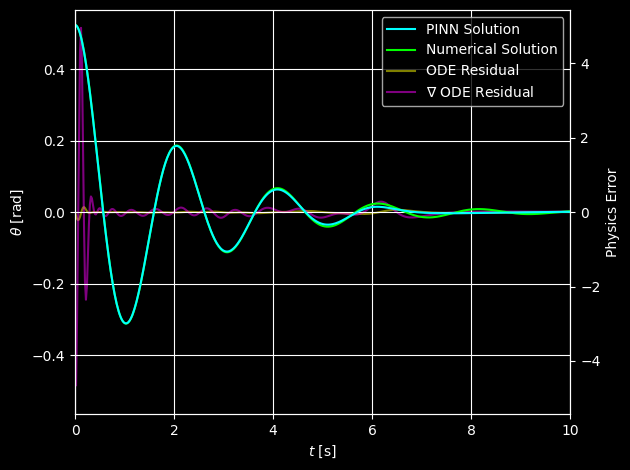

In [108]:
pinn = torch.load(save_path)
pinn.eval()

theta_test = pinn(t_test)
residuals = residual(pinn(t_test), t_test)
grad_residuals = torch.autograd.grad(residuals, t_test, torch.ones_like(residuals), create_graph=True)[0]


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False)

line_residual = ax2.plot(t_test.detach().numpy(), residuals.detach().numpy(), color="yellow", alpha=0.5)
line_grad_residual = ax2.plot(t_test.detach().numpy()[1:], grad_residuals.detach().numpy()[1:], color="magenta", alpha=0.5)
line_num = ax1.plot(num_solution.t, num_solution.y[0], color="lime")
line_pinn = ax1.plot(t_test.detach().numpy(), pinn(t_test).detach().numpy(), color="cyan")


ax1.legend(line_pinn + line_num + line_residual + line_grad_residual, ["PINN Solution", "Numerical Solution", "ODE Residual", r"$\nabla$ ODE Residual"])

ax1.set_xlabel(r"$t$ [s]")
ax1.set_ylabel(r"$\theta$ [rad]")
ax2.set_ylabel("Physics Error")
ax1.set_xlim([0, t_end])

ax1.grid()

align.yaxes(ax1, 0, ax2, 0, 0.5)

plt.tight_layout()

fig.savefig(f"output/pinn_plot_" + description + ".png", dpi=300)
plt.show()

Animate the training process.

In [111]:
slicing_interval = 10
solutions_sliced = solutions[slicing_interval - 1::slicing_interval, :, :]

fig, ax = plt.subplots()

nn_curve, = ax.plot(t_test.detach().numpy(), solutions_sliced[0, 0, :], color = "cyan", zorder=3)
func_curve, = ax.plot(num_solution.t, num_solution.y[0], color = "lime")

ax.set_xlim([0, t_end])
ax.set_ylim([-theta_0, theta_0])
ax.set_title("Epoch = 0")
ax.grid()
ax.legend(["NN", "Function"])

def animate(i):
    nn_curve.set_data(t_test.detach().numpy(), solutions_sliced[i, 0, :])
    ax.set_title(f"Epoch = {(i + 1) * slicing_interval}")

anim = animation.FuncAnimation(fig, animate, frames=len(solutions_sliced), interval=20)
# anim.save(f"output/training_hidden_{hidden_depth}_{hidden_width}_t_0_{t_end}_n_{num_physics_pts}_lr_{lr}_epochs_{epochs}.mp4", dpi=300, writer=animation.FFMpegWriter(fps=50))
# anim.save(f"output/training_hidden_{hidden_depth}_{hidden_width}_t_0_{t_end}_n_{num_physics_pts}_lr_{lr}_epochs_{epochs}.gif", dpi=300, writer=animation.PillowWriter(fps=50))
plt.close()

Animate the results.

In [113]:
fig = plt.figure(figsize = (7,7))

ax_pendulum = plt.subplot(2, 2, 1, aspect='equal')
ax_pendulum.set_xlim([-1.2*l, 1.2*l])
ax_pendulum.set_ylim([-1.8*l, 0.6*l])
ax_pendulum.set_xticks([])
ax_pendulum.set_yticks([])

mass_x = np.sin(num_solution.y[0, :])
mass_y = -np.cos(num_solution.y[0, :])
rod, = ax_pendulum.plot([0, mass_x[0]], [0, mass_y[0]], color="cyan")
mass, = ax_pendulum.plot(mass_x[0], mass_y[0], "o", color="cyan")

ax_phase = plt.subplot(2, 2, 2)
ax_phase.set_xlim([-np.max(np.abs(num_solution.y[0, :])), np.max(np.abs(num_solution.y[0, :]))])
ax_phase.set_ylim([-np.max(np.abs(num_solution.y[1, :])), np.max(np.abs(num_solution.y[1, :]))])
ax_phase.set_xlabel(r"$\theta$ [rad]")
ax_phase.set_ylabel(r"$\dot{\theta}$ [rad/s]")
ax_phase.grid()

phase_curve, = ax_phase.plot(num_solution.y[0, 0], num_solution.y[1, 0], color="cyan")
current_phase, = ax_phase.plot(num_solution.y[0, 0], num_solution.y[1, 0], marker="o", color="cyan")

ax_solution = plt.subplot(2, 2, (3, 4))
ax_solution.set_xlim([num_solution.t[0], num_solution.t[-1]])
ax_solution.set_ylim([-np.max(np.abs(num_solution.y)), np.max(np.abs(num_solution.y))])
ax_solution.set_xlabel(r"$t$ [s]")
ax_solution.set_ylabel(r"$\theta$ [rad], $\dot{\theta}$ [rad/s]")
ax_solution.grid()

theta_curve, = ax_solution.plot(num_solution.t[0], num_solution.y[0, 0], color="cyan")
theta_dot_curve, = ax_solution.plot(num_solution.t[0], num_solution.y[1, 0], color="cyan", linestyle="dashed")
current_theta, = ax_solution.plot(num_solution.t[0], num_solution.y[0, 0], marker="o", color="cyan")
current_theta_dot, = ax_solution.plot(num_solution.t[0], num_solution.y[1, 0], marker="o", color="cyan")
ax_solution.legend([theta_curve, theta_dot_curve], [r"$\theta$ [rad]", r"$\dot{\theta}$ [rad/s]"], loc="upper right")

plt.tight_layout(pad=1.35)

def animate(i):
    rod.set_data([0, mass_x[i]], [0, mass_y[i]])
    mass.set_data(mass_x[i:i+1], mass_y[i:i+1])

    phase_curve.set_data(num_solution.y[0, :i+1], num_solution.y[1, :i+1])
    current_phase.set_data(num_solution.y[0, i:i+1], num_solution.y[1, i:i+1])

    theta_curve.set_data(num_solution.t[:i+1], num_solution.y[0, :i+1])
    theta_dot_curve.set_data(num_solution.t[:i+1], num_solution.y[1, :i+1])
    current_theta.set_data(num_solution.t[i:i+1], num_solution.y[0, i:i+1])
    current_theta_dot.set_data(num_solution.t[i:i+1], num_solution.y[1, i:i+1])

anim = animation.FuncAnimation(fig, animate, frames=len(num_solution.t), interval=h*1000)
# anim.save(f"output/numerical_results_m_{m}_l_{l}_b_{b}.mp4", dpi=300, writer=animation.FFMpegWriter(fps=50))
# anim.save(f"output/numerical_results_m_{m}_l_{l}_b_{b}.gif", dpi=300, writer=animation.PillowWriter(fps=50))
plt.close()